Credit on some of this goes to: https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import datetime

%matplotlib inline

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

In [2]:
train_frame = pd.read_csv("./input/train_flat_pre.csv")
test_frame = pd.read_csv("./input/test_flat_pre.csv")

c:\users\steve\.virtualenvs\gstore-okygrqzl\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train_frame.fillna(0, inplace=True)
test_frame.fillna(0, inplace=True)
train_y = train_frame["totals.transactionRevenue"].values
train_id = train_frame["fullVisitorId"].values
test_id = test_frame["fullVisitorId"].values

cat_feats = ["channelGrouping", "device.browser", "device.deviceCategory", "device.operatingSystem", 
             "geoNetwork.city", "geoNetwork.continent", "geoNetwork.country", "geoNetwork.metro",
             "geoNetwork.networkDomain", "geoNetwork.region", "geoNetwork.subContinent", "trafficSource.adContent", 
             "trafficSource.adwordsClickInfo.adNetworkType", "trafficSource.adwordsClickInfo.gclId", 
             "trafficSource.adwordsClickInfo.page", "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
             "trafficSource.keyword", "trafficSource.medium", "trafficSource.referralPath", 
             "trafficSource.source", 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for feature in cat_feats:
    lab_enc = preprocessing.LabelEncoder()
    lab_enc.fit(list(train_frame[feature].values.astype('str')) + list(test_frame[feature].values.astype('str')))
    train_frame[feature] = lab_enc.transform(list(train_frame[feature].values.astype('str')))
    test_frame[feature] = lab_enc.transform(list(test_frame[feature].values.astype('str')))
    
num_feats_visit = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
num_feats = ["totals.hits", "totals.pageviews", "visitNumber", 'totals.bounces',  'totals.newVisits']    
for feature in num_feats:
    train_frame[feature] = train_frame[feature].astype(float)
    test_frame[feature] = test_frame[feature].astype(float)
    
train_frame["date"] = pd.to_datetime(train_frame["date"], format="%Y%m%d")

In [4]:
## BALANCE CLASSES
#pos_rev = train_frame[train_frame["totals.transactionRevenue"] > 0]
#no_rev = train_frame[train_frame["totals.transactionRevenue"] <= 0.00001]
#no_rev_sample = no_rev.sample(n=t, replace=False)
#train_balanced = pd.concat([pos_rev, no_rev_sample])

In [5]:
# We need to split into development and validation sets
dev_frame = train_frame[(train_frame['date'] >= '2017-5-1') & (train_frame['date'] <= '2018-4-30')]
val_frame = pd.concat([train_frame, dev_frame]).drop_duplicates(keep=False)
dev_y = np.log1p(dev_frame["totals.transactionRevenue"].values)
val_y = np.log1p(val_frame["totals.transactionRevenue"].values)

dev_X = dev_frame[cat_feats + num_feats] 
dev_X_visit = dev_frame[cat_feats + num_feats_visit] 
val_X = val_frame[cat_feats + num_feats] 
val_X_visit = val_frame[cat_feats + num_feats_visit] 
test_X = test_frame[cat_feats + num_feats]
test_X_visit = test_frame[cat_feats + num_feats_visit]

In [6]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 100,
        "min_child_samples" : 200,
        "learning_rate" : 0.02,
        "bagging_fraction" : 0.75,
        "feature_fraction" : 0.8,
        "bagging_frequency" : 12,
        "bagging_seed" : 49,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=200, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the LGBM model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
pred_test_visit, model_visit, pred_val_visit = run_lgb(dev_X_visit, dev_y, val_X_visit, val_y, test_X_visit)

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 1.62576
[200]	valid_0's rmse: 1.6192
[300]	valid_0's rmse: 1.62
[400]	valid_0's rmse: 1.62186
Early stopping, best iteration is:
[219]	valid_0's rmse: 1.61885
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 1.65613
[200]	valid_0's rmse: 1.70887
Early stopping, best iteration is:
[72]	valid_0's rmse: 1.64626


In [7]:
from sklearn import metrics
# Without visitTime
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_frame["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_frame["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
val_pred_df["Zero"] = 0
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue", "Zero"].sum().reset_index()
# With visitTime
pred_val_visit[pred_val_visit<0] = 0
val_pred_df_visit = pd.DataFrame({"fullVisitorId":val_frame["fullVisitorId"].values})
val_pred_df_visit["transactionRevenue"] = val_frame["totals.transactionRevenue"].values
val_pred_df_visit["PredictedRevenue"] = np.expm1(pred_val_visit)
val_pred_df_visit["Zero"] = 0
val_pred_df_visit = val_pred_df_visit.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue", "Zero"].sum().reset_index()


print("Mean Squared Error Rate for LGBM (without visitTime): ", np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
print("Mean Squared Error Rate for LGBM (with visitTime): ", np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df_visit["transactionRevenue"].values), np.log1p(val_pred_df_visit["PredictedRevenue"].values))))
print("Mean Squared Error Rate for Guess 0: ", np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["Zero"].values))))

Mean Squared Error Rate for LGBM (without visitTime):  1.589718721551667
Mean Squared Error Rate for LGBM (with visitTime):  1.6396979254030228
Mean Squared Error Rate for Guess 0:  2.0408680510291712


In [8]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb.csv", index=False)

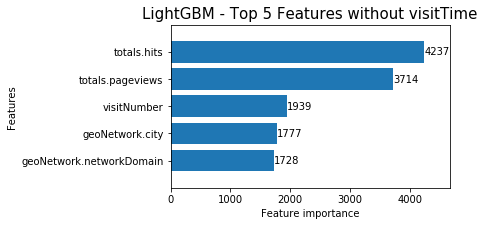

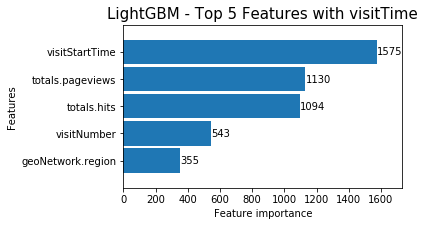

In [9]:
fig, ax = plt.subplots(figsize=(5,3))
lgb.plot_importance(model, max_num_features=5, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Top 5 Features without visitTime", fontsize=15)
plt.show()

fig_visit, ax_visit = plt.subplots(figsize=(5,3))
lgb.plot_importance(model_visit, max_num_features=5, height=0.9, ax=ax_visit)
ax_visit.grid(False)
plt.title("LightGBM - Top 5 Features with visitTime", fontsize=15)
plt.show()

In [11]:
# Setting up Random Forest Model
from sklearn.ensemble import RandomForestRegressor

def run_forest(train_X, train_y, val_X, val_y, test_X, rand=0):
    
    rand_forest = RandomForestRegressor(        
        n_estimators=100,
        max_depth=5,
        random_state=rand)
    rand_forest.fit(dev_X, dev_y)
    
    pred_test_y = rand_forest.predict(test_X)
    pred_val_y = rand_forest.predict(val_X)
    return pred_test_y, model, pred_val_y

pred_test, model, pred_val = run_forest(dev_X, dev_y, val_X, val_y, test_X)

In [12]:
from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_frame["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_frame["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print("Mean Squared Error Rate for Random Forest: ", np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

Mean Squared Error Rate for Random Forest:  1.6484809292668443
